In [2]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from env_utils import PDUSession
from nfv_allocation_cpu_env import NfvAllocEnv
from nfv_allocation_cpu_env_duration import NfvAllocEnvDuration
from nfv_allocation_cpu_env_rew import NfvAllocEnvRew
from stable_baselines3 import PPO, A2C, DQN, TD3
from sb3_contrib import MaskablePPO, RecurrentPPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib.common.maskable.evaluation import evaluate_policy

2025-01-28 15:35:28.943498: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 15:35:29.088482: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-28 15:35:29.764618: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 15:35:29.765077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 15:35:29.892194: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
qi_dict = {3:0.3, 5:0.4, 9:0.3}
#qi_dict = {3:0.6, 5:0.3, 9:0.1}
env_par={'config_file': 'nuc_host_models.json', 'obs_metric':'power', 'rw_metric':'power', 'flat_lerr': False, 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
#env_par={'config_file': 'nuc_host_models-4.json', 'dt_scale': 1, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}

#env = NfvAllocEnv(**env_par)
#env = NfvAllocEnvDuration(**env_par)
env = NfvAllocEnvRew(**env_par)

seed = None
gamma = 0.05
n_steps = 1_000

env.set_gamma(gamma)

step_data = []
run_data = []

In [3]:
drl_model = MaskablePPO.load(path='saved models/PPO_rew10_net128_scale1.5_env8_nuc_power_qi359_p343')
#drl_model = RecurrentPPO.load('saved models/RecurrentPPO_dur_scale1.5_env8_random3_power_llearn_flat_npseedNone_g05_qi359_p343')
#drl_model = DQN.load('saved models/DQN_dur_scale1.5_env8_random_power_llearn_flat_npseedNone_g1_qi359_p343')
drl_model_cpu = MaskablePPO.load(path='saved models/PPO_rew10_net128_scale1.5_env8_nuc_cpu_qi359_p343')

f = open('5qi_table.json')
qi_table = json.load(f)

def drl_policy(obs, mask):
    action, _states = drl_model.predict(obs, action_masks=mask, deterministic=True)
    return action
    
def drl_policy_nomask(obs):
    action, _states = drl_model.predict(obs, deterministic=True)
    return action

def recurrent_drl_policy(obs, lstm_states):
    action, lstm_states = drl_model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
    return action, lstm_states

In [4]:
# return the host with the lowest current energy that is not full. How to handle on/off nodes?
def energy_greedy_policy(obs, action_mask):
    # energy greedy alway choose the cloud?
    action = 0
    return action

In [5]:
# return the host with the lowest latency that is not full. How to handle on/off nodes?
def latency_greedy_policy(obs, action_mask):
    available_hosts = np.argwhere(mask).flatten()
    #print('available hosts: ',available_hosts)
    latencies = obs[:,3]
    #print('latencies: ', latencies)
    action = available_hosts[np.argmin(latencies[available_hosts])]
    #print('action: ',action)
    return action

In [6]:
def random_action_policy(obs, action_mask):
    available_hosts = np.argwhere(mask).flatten()
    action = available_hosts[np.random.randint(available_hosts.size)]
    return action

In [7]:
#choose the host with maximum latency between the ones that satisfy the required latency otherwise minimize latency error
def latency_smart_policy(obs, action_mask):
    available_hosts = np.argwhere(mask).flatten()
    #print('available hosts: ',available_hosts)
    latencies = obs[:,3]
    #print('latencies: ', latencies)
    #required_lat = PDUSession.latencies[int(obs[0,4])]
    req_qi = int(obs[0,4])
    #required_lat = qi_table[str(req_qi)]["delay"]
    required_lat = req_qi #NOTE: I canged the observation from the 5qi to the latency
    #print('required lat: ', required_lat)
    
    av_latencies = latencies[available_hosts]
    good_latencies = np.where(av_latencies <= required_lat)[0]
    #print('good latencies: ', good_latencies)
    if good_latencies.size != 0:
        #print('smart!')
        action = available_hosts[good_latencies[np.argmax(latencies[good_latencies])]]
    else:
        action = available_hosts[np.argmin(latencies[available_hosts])]
    #print('action: ',action)
    return action

In [8]:
#DRL POWER
envs = DummyVecEnv([lambda: NfvAllocEnvRew(**env_par)])
envs = VecNormalize(envs, norm_reward=False) 

drl_lat_errors = []
drl_ppmbit = []
choices = []
drl_rewards = []
tot_rew = 0

envs.seed(seed)
obs = envs.reset()
#info = envs.reset_infos
#print(info)

for step in tqdm(range(n_steps)):
    mask = np.array(envs.env_method("action_masks"))
    action = drl_model.predict(obs, action_masks=mask)
    qi= envs.env_method("get_current_qi")
    choices.append(["drl power", int(qi[0]), int(action[0])])
    obs, reward, dones, info = envs.step(action)
    tot_rew += reward[0]
    drl_rewards.append(reward[0])
    drl_lat_errors.append(info[0]['latency_error'])
    drl_ppmbit.append(info[0]['power_per_mbit'])
    step_data.append(["drl power", step, info[0]['power_per_mbit'], reward[0]])
    
run_data.append(["drl power", np.count_nonzero(drl_lat_errors)/n_steps*100, tot_rew])

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_3775247/2226866879.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choices.append(["drl power", int(qi[0]), int(action[0])])


In [9]:
#DRL CPU
#env_par_cpu={'config_file': 'random_host_models.json', 'obs_metric':'cpu', 'rw_metric':'power', 'flat_lerr': False, 'dt_scale': 1.5, 'duration_mean':40, 'duration_scale':5, 'qi_dict': qi_dict}
env_par_cpu = env_par
env_par_cpu['obs_metric'] = 'cpu'
print(env_par_cpu)
envs = DummyVecEnv([lambda: NfvAllocEnvRew(**env_par_cpu)])
envs = VecNormalize(envs, norm_reward=False) 

drl_lat_errors = []
drl_ppmbit = []
#choices = []
drl_rewards = []
tot_rew = 0

envs.seed(seed)
obs = envs.reset()
#info = envs.reset_infos
#print(info)

for step in tqdm(range(n_steps)):
    mask = np.array(envs.env_method("action_masks"))
    action = drl_model_cpu.predict(obs, action_masks=mask)
    qi= envs.env_method("get_current_qi")
    choices.append(["drl cpu", int(qi[0]), int(action[0])])
    obs, reward, dones, info = envs.step(action)
    tot_rew += reward[0]
    drl_rewards.append(reward[0])
    drl_lat_errors.append(info[0]['latency_error'])
    drl_ppmbit.append(info[0]['power_per_mbit'])
    step_data.append(["drl cpu", step, info[0]['power_per_mbit'], reward[0]])
    
run_data.append(["drl cpu", np.count_nonzero(drl_lat_errors)/n_steps*100, tot_rew])

{'config_file': 'nuc_host_models.json', 'obs_metric': 'cpu', 'rw_metric': 'power', 'flat_lerr': False, 'dt_scale': 1.5, 'duration_mean': 40, 'duration_scale': 5, 'qi_dict': {3: 0.3, 5: 0.4, 9: 0.3}}


  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_3775247/3313392854.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choices.append(["drl cpu", int(qi[0]), int(action[0])])


In [10]:
#LATENCY GREEDY
#n_steps = 1000
lg_lat_errors = []
lg_ppmbit = []
tot_rew = 0

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = latency_greedy_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    tot_rew += reward
    lg_lat_errors.append(info['latency_error'])
    lg_ppmbit.append(info['power_per_mbit'])
    step_data.append(["latency greedy", step, info['power_per_mbit'], reward])
    
run_data.append(["latency greedy", np.count_nonzero(lg_lat_errors)/n_steps*100, tot_rew])
env.print_env()

  0%|          | 0/1000 [00:00<?, ?it/s]

current time:  1552.533730425146
env action mask:  [ True  True  True  True]
-- Cloud host --
power coefficient:  0.01
base latency:  200
current traffic:  0
current power consumption:  0.0
session counter:  3
active sessions:  0
[]
-- Edge host --
power model:  [9.473, 10.676, 12.446, 14.772, 17.884, 20.989, 24.056, 27.031, 28.718, 29.832, 30.468]
base latency:  20
max traffic:  700
current traffic:  500.41014921930866
current power consumption:  27.281881
is on:  True
turned off times:  2
session counter:  287
active sessions:  7
qos indicator:  [5, 3, 9, 3, 3, 9, 9]
-- Edge host --
power model:  [8.2, 8.943, 9.715, 10.492, 11.472, 13.079, 14.183, 15.24, 16.182, 16.918, 17.336]
base latency:  40
max traffic:  800
current traffic:  0
current power consumption:  0
is on:  False
turned off times:  10
session counter:  109
active sessions:  0
qos indicator:  []
-- Edge host --
power model:  [7.9, 9.623, 10.925, 12.4, 14.207, 16.064, 17.831, 19.103, 20.079, 20.88, 21.555]
base latency:  1

In [11]:
#ENERGY GREEDY
#n_steps = 1000
eg_lat_errors = []
eg_ppmbit = []
tot_rew = 0

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = energy_greedy_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    tot_rew += reward
    eg_lat_errors.append(info['latency_error'])
    eg_ppmbit.append(info['power_per_mbit'])
    step_data.append(["energy greedy", step, info['power_per_mbit'], reward])
    
run_data.append(["energy greedy", np.count_nonzero(eg_lat_errors)/n_steps*100, tot_rew])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
#RANDOM ACTION
#n_steps = 1000
rand_lat_errors = []
rand_ppmbit = []
tot_rew = 0

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = random_action_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    tot_rew += reward
    rand_lat_errors.append(info['latency_error'])
    rand_ppmbit.append(info['power_per_mbit'])
    step_data.append(["random action", step, info['power_per_mbit'], reward])
    
run_data.append(["random action", np.count_nonzero(rand_lat_errors)/n_steps*100, tot_rew])
#env.print_env()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
#LATENCY SMART
#n_steps = 1000
ls_lat_errors = []
ls_ppmbit = []
tot_rew = 0

obs, info = env.reset(seed=seed)

for step in tqdm(range(n_steps)):
    mask = env.action_masks()
    action = latency_smart_policy(obs, mask)
    obs, reward, _, _, info = env.step(action)
    tot_rew += reward
    ls_lat_errors.append(info['latency_error'])
    ls_ppmbit.append(info['power_per_mbit'])
    step_data.append(["latency smart", step, info['power_per_mbit'], reward])
    
run_data.append(["latency smart", np.count_nonzero(ls_lat_errors)/n_steps*100, tot_rew])
env.print_env()

  0%|          | 0/1000 [00:00<?, ?it/s]

current time:  1448.4371400537025
env action mask:  [ True  True  True  True]
-- Cloud host --
power coefficient:  0.01
base latency:  200
current traffic:  1061.624033041804
current power consumption:  10.616240000000001
session counter:  319
active sessions:  22
[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]
-- Edge host --
power model:  [9.473, 10.676, 12.446, 14.772, 17.884, 20.989, 24.056, 27.031, 28.718, 29.832, 30.468]
base latency:  20
max traffic:  700
current traffic:  0
current power consumption:  0
is on:  False
turned off times:  107
session counter:  107
active sessions:  0
qos indicator:  []
-- Edge host --
power model:  [8.2, 8.943, 9.715, 10.492, 11.472, 13.079, 14.183, 15.24, 16.182, 16.918, 17.336]
base latency:  40
max traffic:  800
current traffic:  655.7535769382741
current power consumption:  16.3269368
is on:  True
turned off times:  0
session counter:  503
active sessions:  13
qos indicator:  [5, 3, 3, 3, 5, 5, 3, 3, 3, 5, 5, 3, 5]
-- Edge h

In [14]:
step_df = pd.DataFrame(step_data, columns=['algorithm', 'step','power', 'reward'])
run_df = pd.DataFrame(run_data, columns=['algorithm', 'error percent', 'episode reward'])
choices_df = pd.DataFrame(choices, columns=['metric','5qi', 'host'])

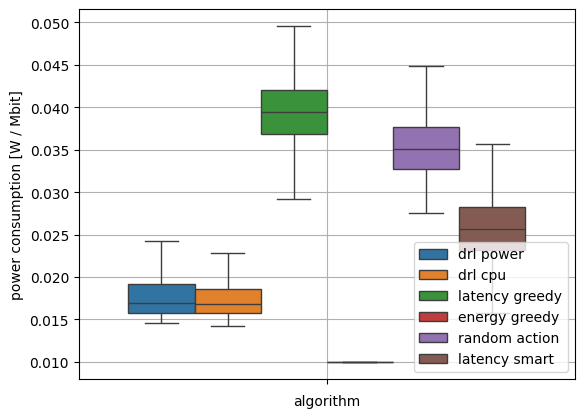

In [15]:
sns.boxplot(data=step_df, y="power", hue="algorithm", showfliers=False)
plt.xlabel("algorithm")
plt.ylabel("power consumption [W / Mbit]")
plt.grid()
plt.legend( loc=4)

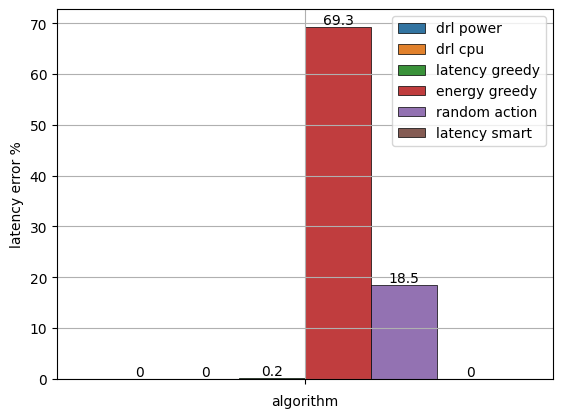

In [16]:
ax=sns.barplot(data=run_df, y="error percent", hue="algorithm", linewidth=.5, edgecolor="0")
plt.ylabel("latency error %")
plt.xlabel("algorithm")
plt.grid()
#plt.yscale('log')
ax.legend_.set_title(None)
for i in ax.containers:
    ax.bar_label(i,)

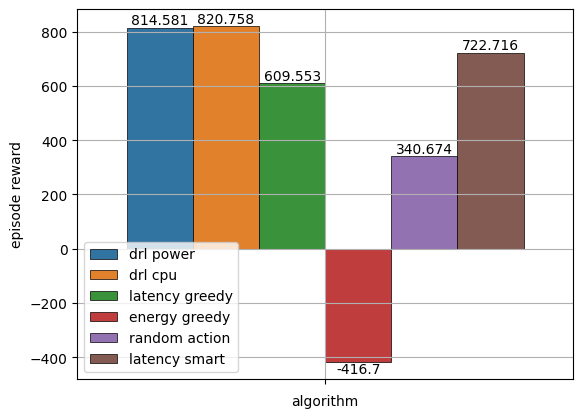

In [17]:
ax = sns.barplot(data=run_df, y="episode reward", hue="algorithm", linewidth=.5, edgecolor="0")
plt.xlabel("algorithm")
plt.legend(loc=3)
plt.grid()
ax.legend_.set_title(None)
for i in ax.containers:
    ax.bar_label(i,)

Text(0.5, 1.0, 'drl cpu')

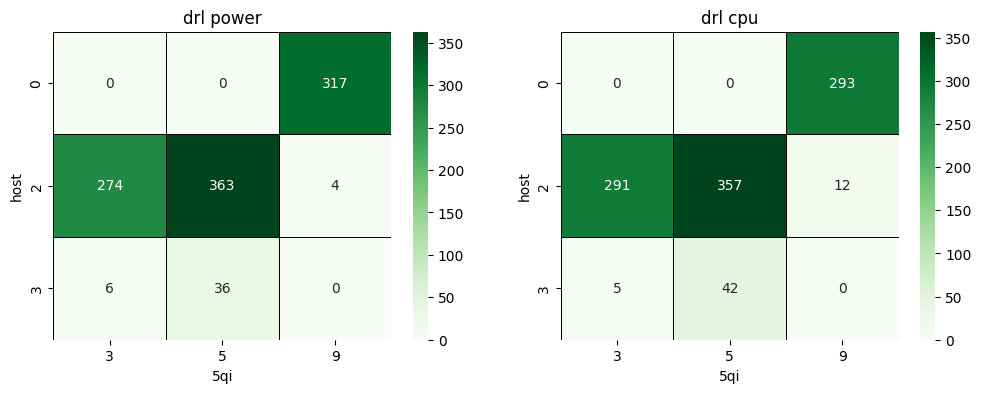

In [18]:
ccp = choices_df.loc[choices_df['metric'] == "drl power"]
ccc = choices_df.loc[choices_df['metric'] == 'drl cpu']
cdf_p = pd.crosstab(ccp['host'], ccp['5qi'])#.div(len(choices_df))
cdf_c = pd.crosstab(ccc['host'], ccc['5qi'])#.div(len(choices_df))

f, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.heatmap(cdf_p, annot=True, fmt='g',cmap="Greens", linewidths=.5, linecolor='0', ax=axes[0]).set_title("drl power")
sns.heatmap(cdf_c, annot=True, fmt='g',cmap="Greens", linewidths=.5, linecolor='0', ax=axes[1]).set_title("drl cpu")

Latency Smart algorithm performs better in this case because the host with the highest latency inside the requirements also has the lowest power consumption

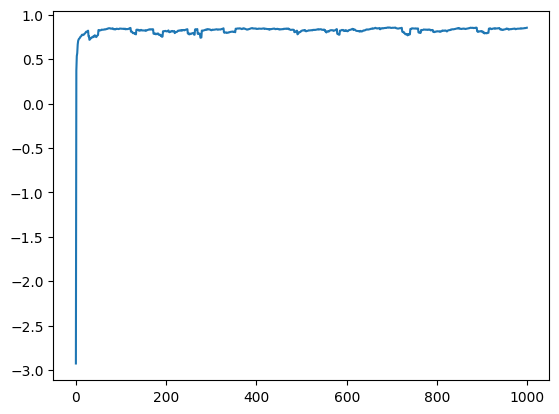

In [19]:
plt.plot(drl_rewards)

In [20]:
drl_model.get_parameters()['policy']['action_net.weight'].size()

torch.Size([4, 128])

In [21]:
print(sns.color_palette().as_hex())

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [22]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]